In [1]:
import tensorflow as tf
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/binary'

# **PREPROCESSING**

In [4]:
# To remove corrupted files before preprocessing
import cv2
import imghdr

In [5]:
img_extension = ['jpeg','jpg','png','bmp']

In [6]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir,image_class,image)
    try:
      # remove files that are too small
      if os.path.getsize(image_path)<7000:
        print ('Corrupted file : {}'.format(image_path))
        os.remove(image_path)
      # remove files if they cannot load in opencv
      img=cv2.imread(image_path)
      # remove files with mismatched extensions
      extension = imghdr.what(image_path)
      if extension not in img_extension:
        print('Image not in extensions list : {}'.format(image_path))
        os.remove(image_path)

    except Exception as e:
        print('Issue with image : {}'.format(image_path))

Corrupted file : /content/drive/MyDrive/binary/sad/vector8.svg
Issue with image : /content/drive/MyDrive/binary/sad/vector8.svg
Corrupted file : /content/drive/MyDrive/binary/sad/vector9.svg
Issue with image : /content/drive/MyDrive/binary/sad/vector9.svg
Corrupted file : /content/drive/MyDrive/binary/sad/vector7.svg
Issue with image : /content/drive/MyDrive/binary/sad/vector7.svg
Corrupted file : /content/drive/MyDrive/binary/sad/vector10.svg
Issue with image : /content/drive/MyDrive/binary/sad/vector10.svg
Corrupted file : /content/drive/MyDrive/binary/sad/vector5.svg
Issue with image : /content/drive/MyDrive/binary/sad/vector5.svg
Corrupted file : /content/drive/MyDrive/binary/sad/vector2.svg
Issue with image : /content/drive/MyDrive/binary/sad/vector2.svg
Corrupted file : /content/drive/MyDrive/binary/sad/vector.svg
Issue with image : /content/drive/MyDrive/binary/sad/vector.svg
Corrupted file : /content/drive/MyDrive/binary/sad/vector4.svg
Issue with image : /content/drive/MyDrive

In [7]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 210 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
# Images as numpy arrays
batch = data_iterator.next()
batch[0].shape

(32, 256, 256, 3)

In [12]:
# Label 0 : Happy
# Label 1 : Sad
batch[1]

array([0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0], dtype=int32)

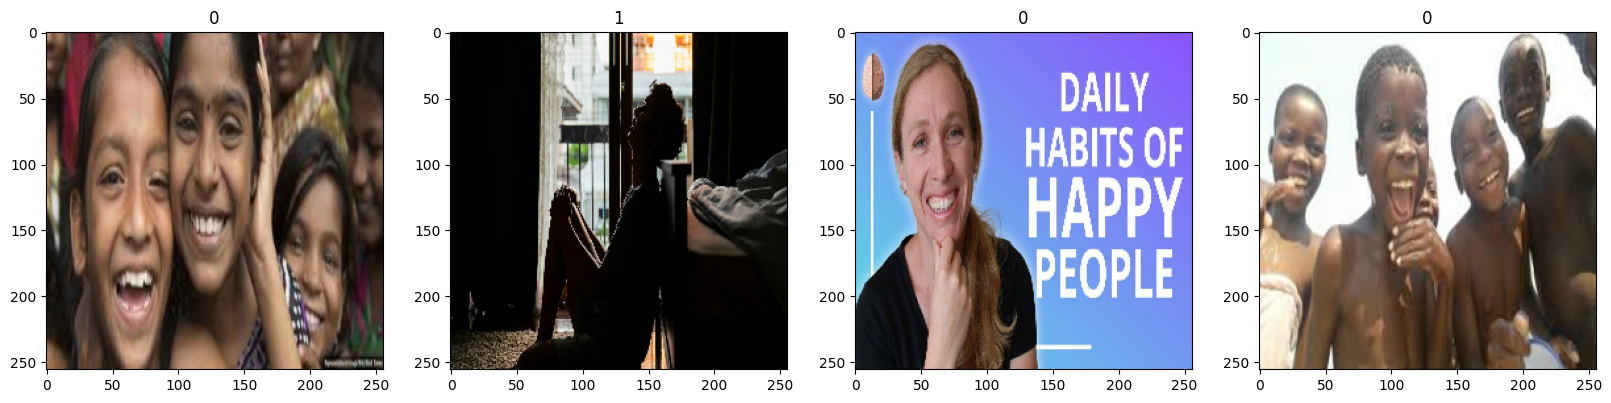

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

In [14]:
# Scaling through API mapping
data = data.map(lambda x,y:(x/255,y))

In [15]:
scaled_iterator = data.as_numpy_iterator()

In [16]:
batch = scaled_iterator.next()

In [17]:
batch[0].max()

1.0

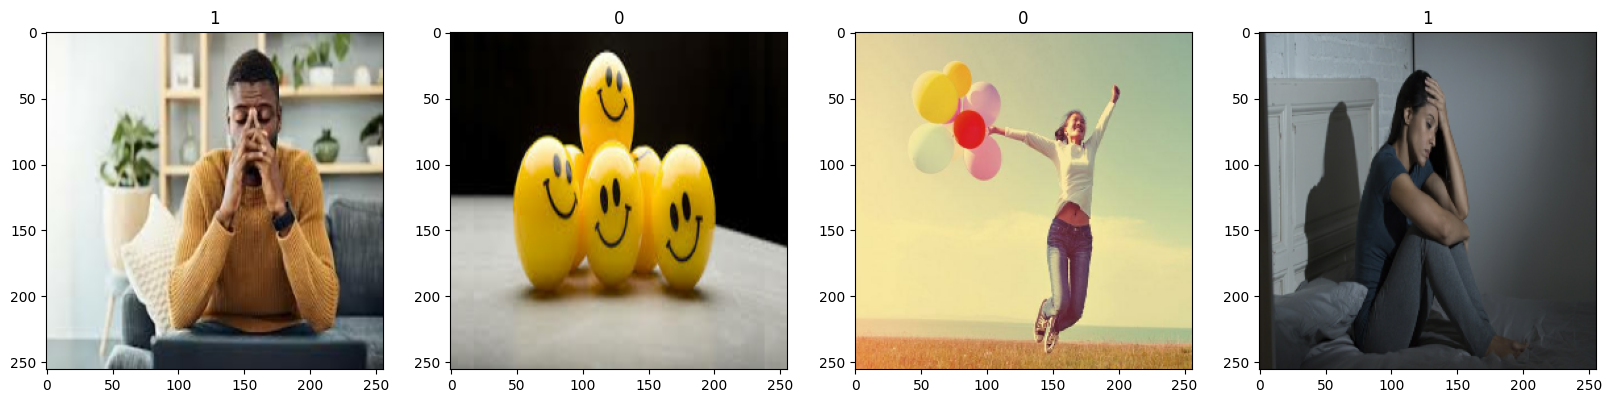

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

# **CNN 2D MODEL**

In [19]:
len(data)

7

In [20]:
train_size = round(len(data)*.7)
val_size = round(len(data)*.2)
test_size = round(len(data)*.1)

In [21]:
train_size + val_size + test_size

7

In [22]:
# Splitting data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [23]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D,MaxPooling2D, Dense, Flatten

In [24]:
model=Sequential()

In [25]:
from tensorflow.python.keras.backend import batch_normalization
# Building Neural Networks
model.add(Conv2D(16,(3,3),1, activation = 'relu', input_shape= (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('Adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

# **TRAINING**

In [28]:
logdir='/content/drive/MyDrive/binarylog'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [30]:
info = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
5/5 [==============================] - 35s 6s/step - loss: 1.2559 - accuracy: 0.4437 - val_loss: 0.6976 - val_accuracy: 0.4688
Epoch 2/20
5/5 [==============================] - 39s 7s/step - loss: 0.6756 - accuracy: 0.6187 - val_loss: 0.7305 - val_accuracy: 0.5625
Epoch 3/20
5/5 [==============================] - 43s 6s/step - loss: 0.5780 - accuracy: 0.6562 - val_loss: 0.5196 - val_accuracy: 0.6562
Epoch 4/20
5/5 [==============================] - 30s 5s/step - loss: 0.5970 - accuracy: 0.6438 - val_loss: 0.6196 - val_accuracy: 0.7188
Epoch 5/20
5/5 [==============================] - 23s 3s/step - loss: 0.5400 - accuracy: 0.7188 - val_loss: 0.5410 - val_accuracy: 0.7500
Epoch 6/20
5/5 [==============================] - 31s 5s/step - loss: 0.4703 - accuracy: 0.7563 - val_loss: 0.5304 - val_accuracy: 0.8750
Epoch 7/20
5/5 [==============================] - 31s 5s/step - loss: 0.5146 - accuracy: 0.7937 - val_loss: 0.4309 - val_accuracy: 0.8438
Epoch 8/20
5/5 [==================

In [31]:
info.history

{'loss': [1.2558718919754028,
  0.6755744814872742,
  0.5779780745506287,
  0.5969918966293335,
  0.5399712324142456,
  0.47032612562179565,
  0.5146298408508301,
  0.45944198966026306,
  0.42355576157569885,
  0.4015834927558899,
  0.34739214181900024,
  0.31692275404930115,
  0.3089005947113037,
  0.24610257148742676,
  0.19970569014549255,
  0.1577247679233551,
  0.13346584141254425,
  0.12314583361148834,
  0.08813749253749847,
  0.05464327335357666],
 'accuracy': [0.4437499940395355,
  0.6187499761581421,
  0.65625,
  0.643750011920929,
  0.71875,
  0.7562500238418579,
  0.793749988079071,
  0.875,
  0.737500011920929,
  0.8812500238418579,
  0.8500000238418579,
  0.949999988079071,
  0.8812500238418579,
  0.9312499761581421,
  0.9437500238418579,
  0.9375,
  0.956250011920929,
  0.956250011920929,
  0.981249988079071,
  1.0],
 'val_loss': [0.6976291537284851,
  0.7305281162261963,
  0.5195533037185669,
  0.6196266412734985,
  0.5410100221633911,
  0.5303511023521423,
  0.43090927

# **PLOTS**

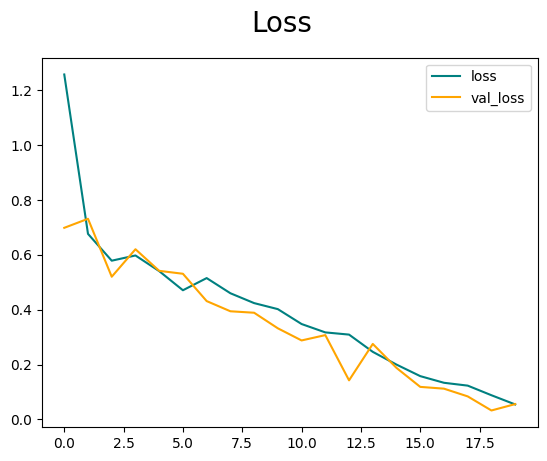

In [32]:
fig = plt.figure()
plt.plot(info.history['loss'], color='teal', label='loss')
plt.plot(info.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

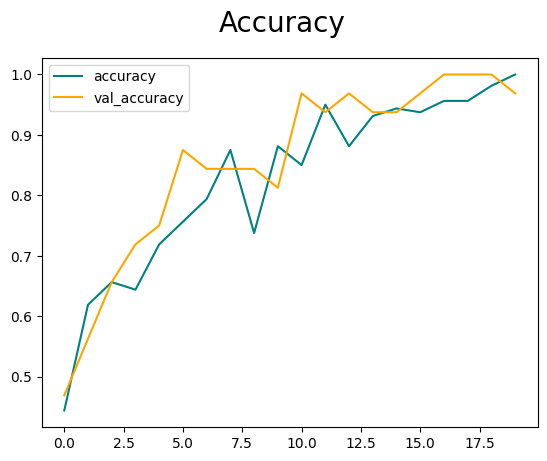

In [34]:
fig = plt.figure()
plt.plot(info.history['accuracy'], color='teal', label='accuracy')
plt.plot(info.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# **TESTING**

In [35]:
from tensorflow.python.keras.metrics import Precision, Recall, BinaryAccuracy

In [36]:
pre = Precision()
re= Recall()
bin= BinaryAccuracy()

In [37]:
len(test)

1

In [38]:
for batch in test.as_numpy_iterator():
  x,y = batch
  pred = model.predict(x)
  pre.update_state(y,pred)
  re.update_state(y,pred)
  bin.update_state(y,pred)

In [39]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {bin.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


In [40]:
happy_path='/content/drive/MyDrive/binarytest/happpy.jpg'
sad_path='/content/drive/MyDrive/binarytest/saddd.jpg'

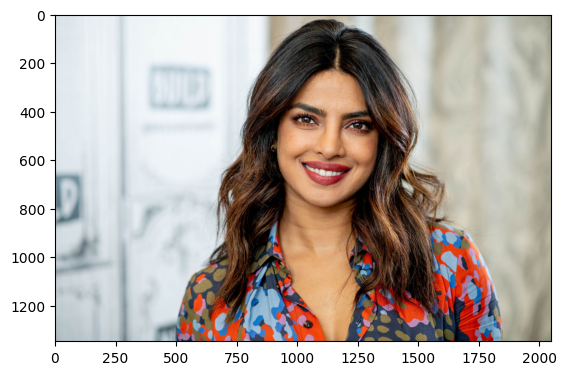

In [41]:
img = cv2.imread(happy_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

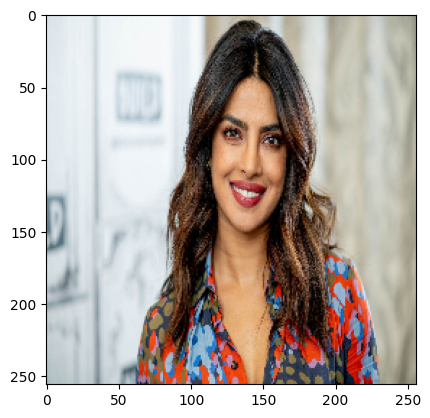

In [42]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [43]:
resize.shape

TensorShape([256, 256, 3])

In [44]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [45]:
pred = model.predict(np.expand_dims(resize/255,0))

In [53]:
if pred<0.5:
  print('Image is predicted to be ',round((1-pred[0][0])*100,4),'% happy')
else:
  print('Image is predicted to be ',round(pred[0][0]*100,4), '% sad')

Image is predicted to be  73.2028 % happy


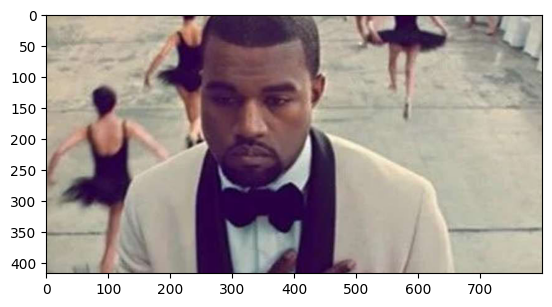

In [54]:
img = cv2.imread(sad_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

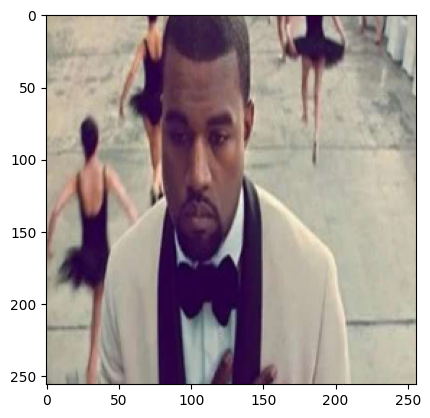

In [55]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [56]:
pred = model.predict(np.expand_dims(resize/255,0))

In [57]:
if pred<0.5:
  print('Image is predicted to be ',round((1-pred[0][0])*100,4),'% happy')
else:
  print('Image is predicted to be ',round(pred[0][0]*100,4), '% sad')

Image is predicted to be  79.7863 % sad
